# 🎨 Timbre: The Color of Sound

This is Part 2 of the Intensity, Loudness & Timbre notebook, focusing on Timbre and its features.

---

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

---

## 6. 🎨 What is Timbre?

### 🔹 Definition

**Timbre** (pronounced "TAM-ber") is the **quality** or **color** of a sound that distinguishes different types of sound production, such as different musical instruments or voices.

### 🔹 The Classic Example

A piano and a violin playing the **same note** (e.g., A4 at 440 Hz) at the **same loudness** sound **different**. This difference is timbre!

### 🔹 Why Timbre Matters for Machine Learning

Timbre is the **primary feature** we extract for audio classification tasks:

1. **Genre Classification**: Rock vs Classical vs Jazz
2. **Instrument Recognition**: Piano vs Guitar vs Violin
3. **Speaker Identification**: Person A vs Person B
4. **Emotion Detection**: Happy vs Sad speech
5. **Audio Event Detection**: Gunshot vs Door slam vs Glass breaking

### 🔹 What Defines Timbre?

Timbre is determined by **two main components**:

1. **Sound Envelope (ADSR)**: How the sound evolves over time
2. **Harmonic Content**: The frequency spectrum and overtones

---

## 7. 📊 Features of Timbre

### 🔹 1. Sound Envelope (ADSR Model)

The **envelope** describes how the amplitude of a sound changes over time. The **ADSR model** breaks this into four phases:

#### **A - Attack**
- **Definition**: Time taken for the sound to reach its peak amplitude
- **Fast Attack**: Percussive instruments (piano, drums) - sharp, immediate
- **Slow Attack**: Bowed strings (violin), wind instruments - gradual buildup

#### **D - Decay**
- **Definition**: Time taken for the sound to drop from peak to sustain level
- **Fast Decay**: Piano - quick drop after initial strike
- **Slow Decay**: Organ - minimal decay

#### **S - Sustain**
- **Definition**: The steady amplitude level maintained while the note is held
- **High Sustain**: Organ, violin (while bowing)
- **No Sustain**: Piano, plucked strings (continuous decay)

#### **R - Release**
- **Definition**: Time taken for the sound to fade to silence after the note ends
- **Fast Release**: Staccato notes
- **Slow Release**: Reverberant sounds, sustained notes

### 🔹 2. Harmonic Content

- **Fundamental Frequency**: The lowest frequency component (determines pitch)
- **Harmonics/Overtones**: Integer multiples of the fundamental
- **Harmonic Ratio**: The relative amplitudes of different harmonics
- Different instruments have different harmonic structures

### 🔹 3. Amplitude Modulation (Tremolo)

- **Definition**: Periodic variation in amplitude
- **Effect**: Creates a "wobbling" or "pulsing" sound
- **Formula**: $y(t) = [1 + m \cdot \cos(2\pi f_m t)] \cdot \cos(2\pi f_c t)$
  - $m$: Modulation depth (0 to 1)
  - $f_m$: Modulation frequency (typically 4-8 Hz)
  - $f_c$: Carrier frequency

### 🔹 4. Frequency Modulation (Vibrato)

- **Definition**: Periodic variation in frequency
- **Effect**: Creates a "warbling" sound
- **Formula**: $y(t) = \cos(2\pi f_c t + \beta \cdot \sin(2\pi f_m t))$
  - $\beta$: Modulation index (frequency deviation)
  - $f_m$: Modulation frequency (typically 5-7 Hz for vibrato)
  - $f_c$: Carrier frequency

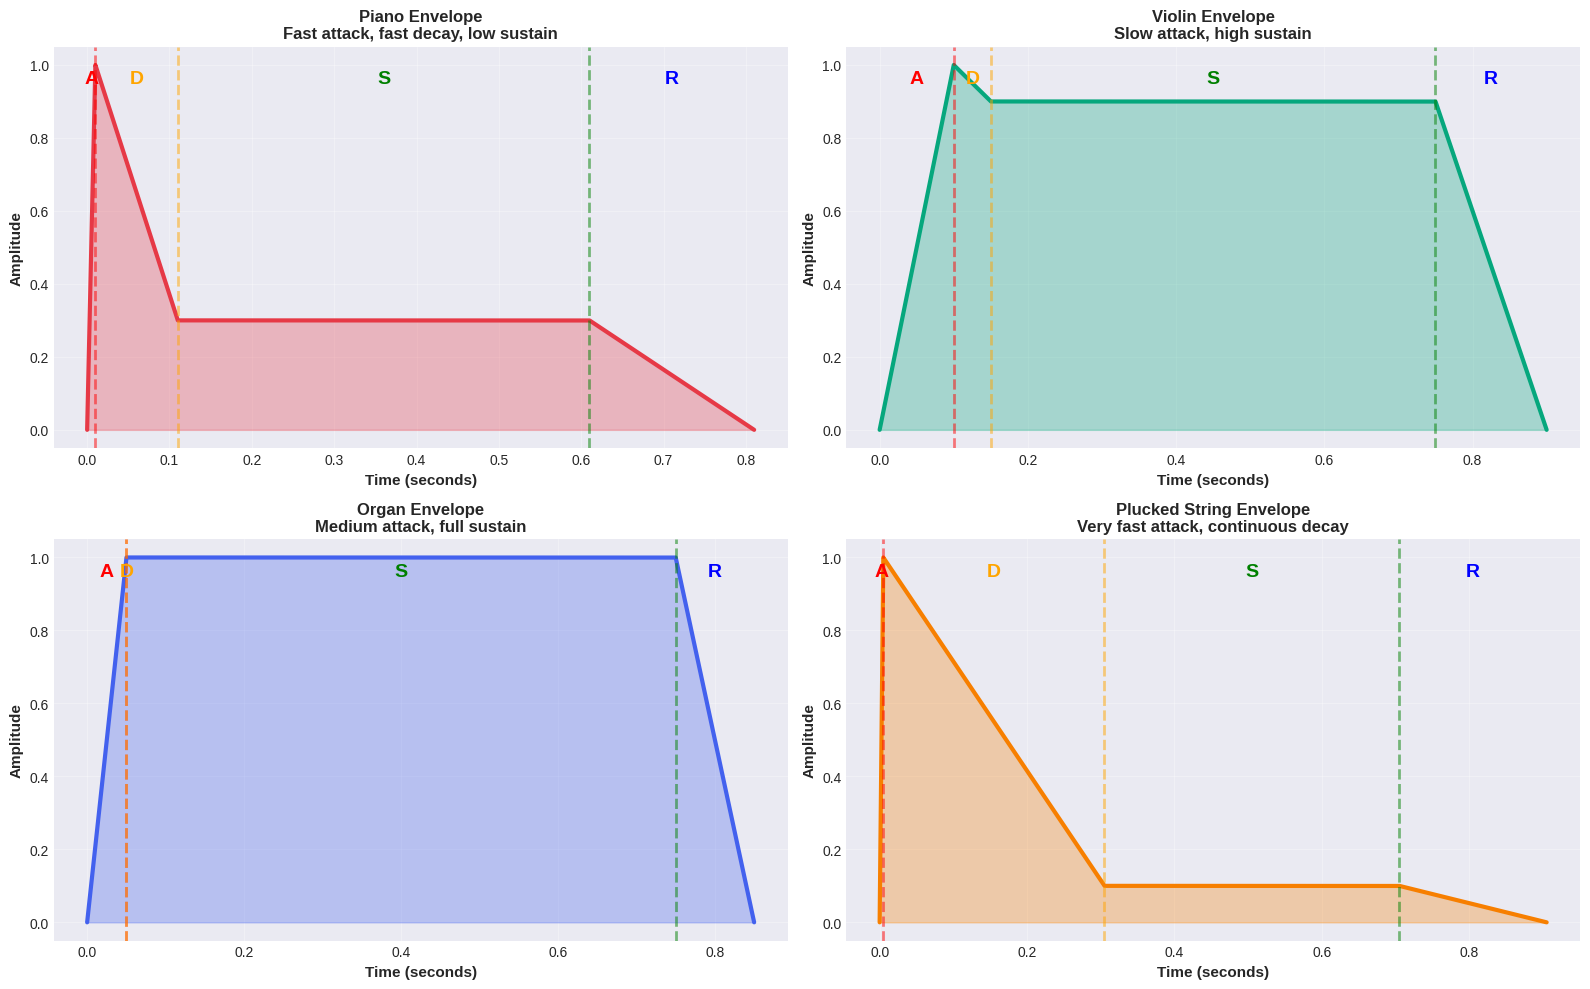


🎵 ADSR Characteristics:
   • Piano: Sharp attack, quick decay, minimal sustain
   • Violin: Gradual attack, long sustain (while bowing)
   • Organ: Steady attack, full sustain, quick release
   • Plucked String: Instant attack, continuous decay


In [2]:
# Demonstrate ADSR envelope
def generate_adsr_envelope(attack, decay, sustain_level, sustain_time, release, sr=44100):
    """
    Generate ADSR envelope
    
    Parameters:
    - attack: Attack time in seconds
    - decay: Decay time in seconds
    - sustain_level: Sustain amplitude (0 to 1)
    - sustain_time: Sustain duration in seconds
    - release: Release time in seconds
    - sr: Sample rate
    """
    # Calculate number of samples for each phase
    attack_samples = int(attack * sr)
    decay_samples = int(decay * sr)
    sustain_samples = int(sustain_time * sr)
    release_samples = int(release * sr)
    
    # Generate each phase
    attack_env = np.linspace(0, 1, attack_samples)
    decay_env = np.linspace(1, sustain_level, decay_samples)
    sustain_env = np.ones(sustain_samples) * sustain_level
    release_env = np.linspace(sustain_level, 0, release_samples)
    
    # Concatenate all phases
    envelope = np.concatenate([attack_env, decay_env, sustain_env, release_env])
    
    return envelope

# Create different ADSR profiles
sr = 44100

# Piano-like: Fast attack, fast decay, no sustain
piano_env = generate_adsr_envelope(0.01, 0.1, 0.3, 0.5, 0.2, sr)

# Violin-like: Slow attack, minimal decay, high sustain
violin_env = generate_adsr_envelope(0.1, 0.05, 0.9, 0.6, 0.15, sr)

# Organ-like: Medium attack, no decay, full sustain
organ_env = generate_adsr_envelope(0.05, 0.0, 1.0, 0.7, 0.1, sr)

# Plucked string: Fast attack, continuous decay
pluck_env = generate_adsr_envelope(0.005, 0.3, 0.1, 0.4, 0.2, sr)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

envelopes = [
    (piano_env, 'Piano', '#E63946', 'Fast attack, fast decay, low sustain'),
    (violin_env, 'Violin', '#06A77D', 'Slow attack, high sustain'),
    (organ_env, 'Organ', '#4361EE', 'Medium attack, full sustain'),
    (pluck_env, 'Plucked String', '#F77F00', 'Very fast attack, continuous decay')
]

for idx, (env, name, color, desc) in enumerate(envelopes):
    ax = axes[idx // 2, idx % 2]
    time = np.arange(len(env)) / sr
    
    ax.plot(time, env, linewidth=3, color=color)
    ax.fill_between(time, 0, env, alpha=0.3, color=color)
    
    # Mark ADSR phases
    if name == 'Piano':
        attack_end = 0.01
        decay_end = 0.11
        sustain_end = 0.61
    elif name == 'Violin':
        attack_end = 0.1
        decay_end = 0.15
        sustain_end = 0.75
    elif name == 'Organ':
        attack_end = 0.05
        decay_end = 0.05
        sustain_end = 0.75
    else:  # Pluck
        attack_end = 0.005
        decay_end = 0.305
        sustain_end = 0.705
    
    ax.axvline(x=attack_end, color='red', linestyle='--', alpha=0.5, linewidth=2)
    ax.axvline(x=decay_end, color='orange', linestyle='--', alpha=0.5, linewidth=2)
    ax.axvline(x=sustain_end, color='green', linestyle='--', alpha=0.5, linewidth=2)
    
    # Add phase labels
    ax.text(attack_end/2, 0.95, 'A', ha='center', fontsize=14, fontweight='bold', color='red')
    ax.text((attack_end + decay_end)/2, 0.95, 'D', ha='center', fontsize=14, fontweight='bold', color='orange')
    ax.text((decay_end + sustain_end)/2, 0.95, 'S', ha='center', fontsize=14, fontweight='bold', color='green')
    ax.text((sustain_end + time[-1])/2, 0.95, 'R', ha='center', fontsize=14, fontweight='bold', color='blue')
    
    ax.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} Envelope\n{desc}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n🎵 ADSR Characteristics:")
print("   • Piano: Sharp attack, quick decay, minimal sustain")
print("   • Violin: Gradual attack, long sustain (while bowing)")
print("   • Organ: Steady attack, full sustain, quick release")
print("   • Plucked String: Instant attack, continuous decay")

---

## 8. 🎹 Piano vs Violin: Sound Envelope Comparison

Let's create a detailed comparison of piano and violin sound envelopes with actual synthesized sounds.

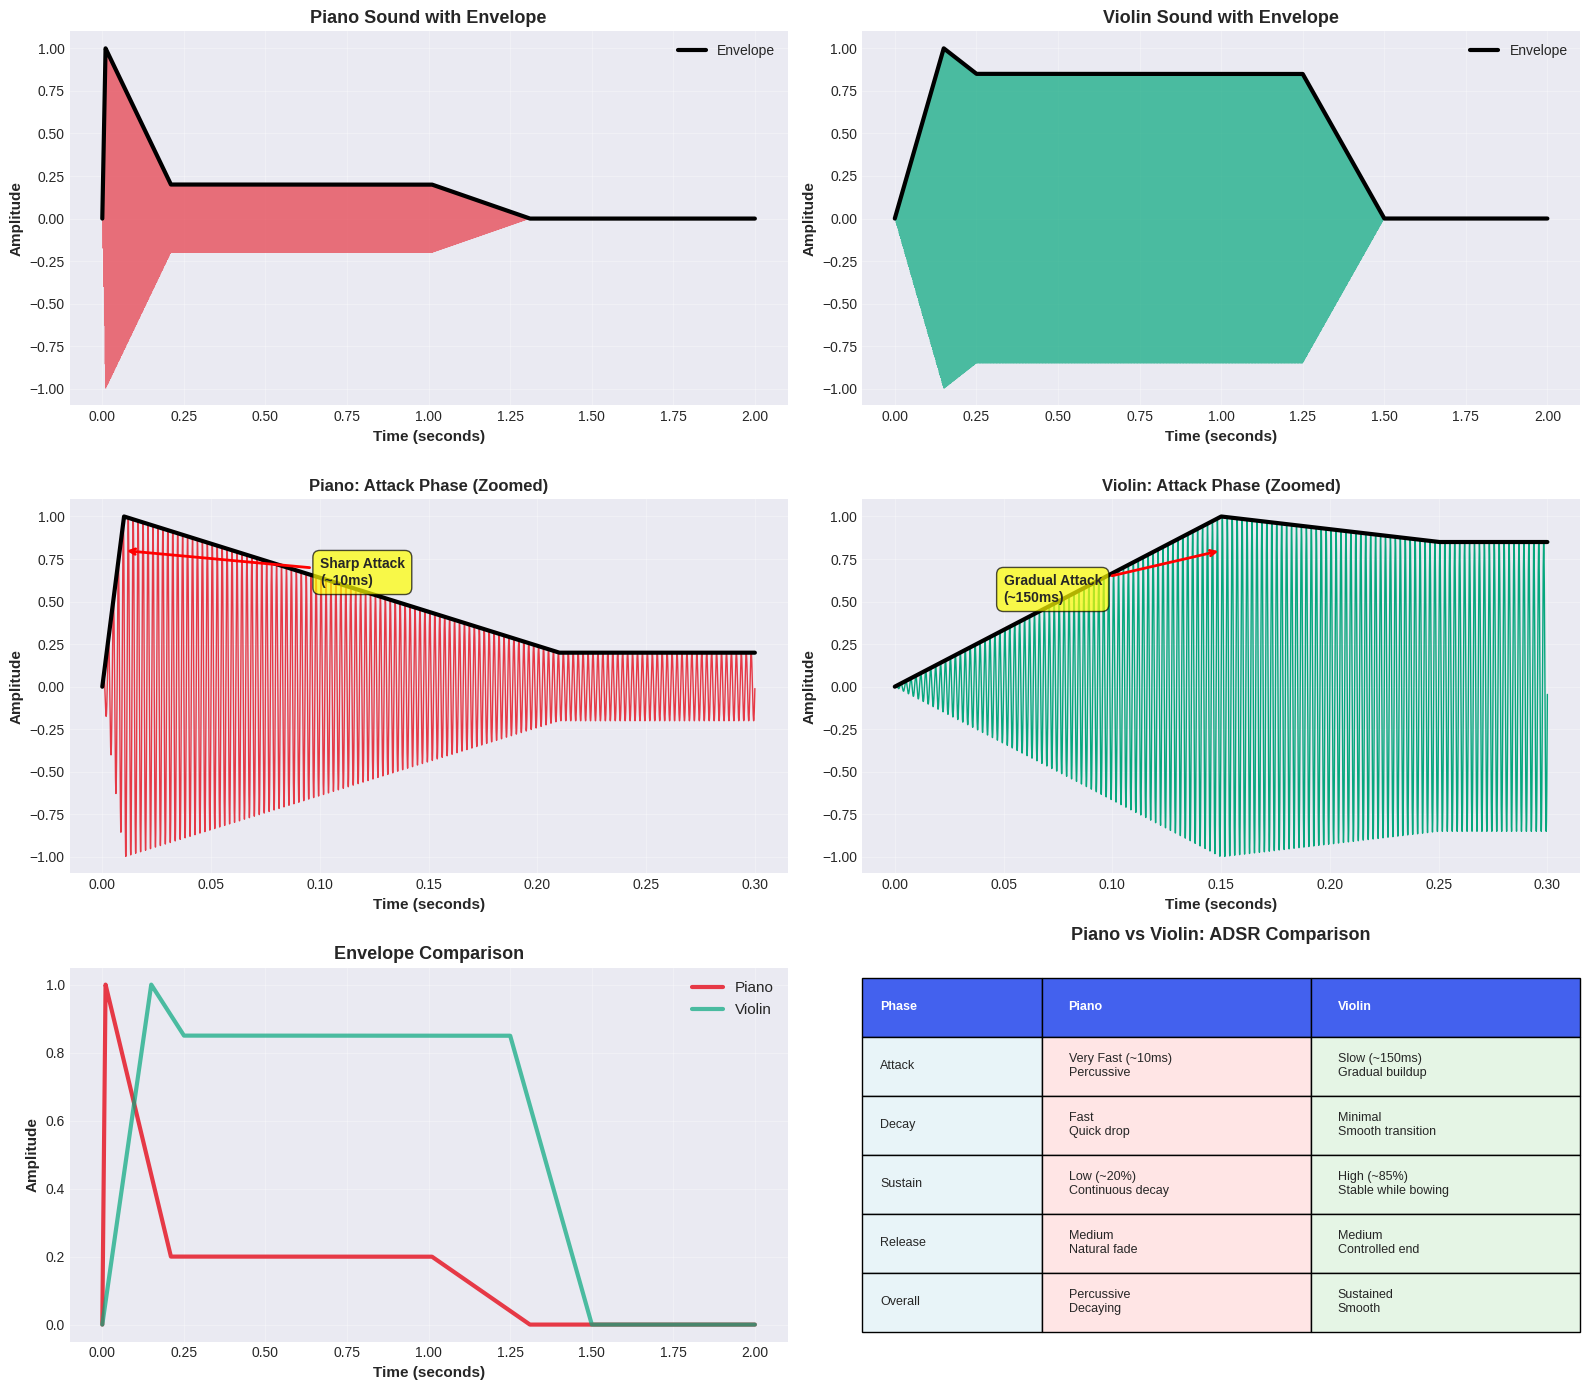


🎼 Key Differences:
   PIANO:
   • Attack: Instant (hammer strikes string)
   • Decay: Rapid (string vibration dampens)
   • Sustain: Low (continuous decay, no energy input)
   • Character: Percussive, transient-rich

   VIOLIN:
   • Attack: Gradual (bow engages string)
   • Decay: Minimal (smooth transition)
   • Sustain: High (bow continuously adds energy)
   • Character: Smooth, sustained, expressive


In [3]:
# Generate piano and violin sounds with ADSR envelopes
sr = 44100
duration = 2.0
f0 = 440  # A4
t = np.linspace(0, duration, int(sr * duration))

# Generate carrier wave (simple sine wave for demonstration)
carrier = np.sin(2 * np.pi * f0 * t)

# Piano envelope
piano_env = generate_adsr_envelope(0.01, 0.2, 0.2, 0.8, 0.3, sr)
# Pad to match duration
if len(piano_env) < len(t):
    piano_env = np.pad(piano_env, (0, len(t) - len(piano_env)), 'constant')
else:
    piano_env = piano_env[:len(t)]

# Violin envelope
violin_env = generate_adsr_envelope(0.15, 0.1, 0.85, 1.0, 0.25, sr)
if len(violin_env) < len(t):
    violin_env = np.pad(violin_env, (0, len(t) - len(violin_env)), 'constant')
else:
    violin_env = violin_env[:len(t)]

# Apply envelopes
piano_sound = carrier * piano_env
violin_sound = carrier * violin_env

# Visualize comparison
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 1 & 2: Full waveforms
axes[0, 0].plot(t, piano_sound, linewidth=0.5, color='#E63946', alpha=0.7)
axes[0, 0].plot(t, piano_env, linewidth=3, color='black', label='Envelope')
axes[0, 0].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Piano Sound with Envelope', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(t, violin_sound, linewidth=0.5, color='#06A77D', alpha=0.7)
axes[0, 1].plot(t, violin_env, linewidth=3, color='black', label='Envelope')
axes[0, 1].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Violin Sound with Envelope', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3 & 4: Zoomed attack phase
attack_samples = int(0.3 * sr)
axes[1, 0].plot(t[:attack_samples], piano_sound[:attack_samples], linewidth=1, color='#E63946')
axes[1, 0].plot(t[:attack_samples], piano_env[:attack_samples], linewidth=3, color='black')
axes[1, 0].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Piano: Attack Phase (Zoomed)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].annotate('Sharp Attack\n(~10ms)', xy=(0.01, 0.8), xytext=(0.1, 0.6),
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', lw=2, color='red'))

axes[1, 1].plot(t[:attack_samples], violin_sound[:attack_samples], linewidth=1, color='#06A77D')
axes[1, 1].plot(t[:attack_samples], violin_env[:attack_samples], linewidth=3, color='black')
axes[1, 1].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Violin: Attack Phase (Zoomed)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].annotate('Gradual Attack\n(~150ms)', xy=(0.15, 0.8), xytext=(0.05, 0.5),
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', lw=2, color='red'))

# Plot 5 & 6: Envelope comparison
axes[2, 0].plot(t, piano_env, linewidth=3, color='#E63946', label='Piano')
axes[2, 0].plot(t, violin_env, linewidth=3, color='#06A77D', label='Violin', alpha=0.7)
axes[2, 0].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[2, 0].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[2, 0].set_title('Envelope Comparison', fontsize=13, fontweight='bold')
axes[2, 0].legend(fontsize=11)
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Comparison table
axes[2, 1].axis('off')
comparison_data = [
    ['Phase', 'Piano', 'Violin'],
    ['Attack', 'Very Fast (~10ms)\nPercussive', 'Slow (~150ms)\nGradual buildup'],
    ['Decay', 'Fast\nQuick drop', 'Minimal\nSmooth transition'],
    ['Sustain', 'Low (~20%)\nContinuous decay', 'High (~85%)\nStable while bowing'],
    ['Release', 'Medium\nNatural fade', 'Medium\nControlled end'],
    ['Overall', 'Percussive\nDecaying', 'Sustained\nSmooth']
]

table = axes[2, 1].table(cellText=comparison_data, cellLoc='left', loc='center',
                         colWidths=[0.25, 0.375, 0.375])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 3)

# Style header row
for i in range(3):
    table[(0, i)].set_facecolor('#4361EE')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows
for i in range(1, 6):
    table[(i, 0)].set_facecolor('#E8F4F8')
    table[(i, 1)].set_facecolor('#FFE5E5')
    table[(i, 2)].set_facecolor('#E5F5E5')

axes[2, 1].set_title('Piano vs Violin: ADSR Comparison', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n🎼 Key Differences:")
print("   PIANO:")
print("   • Attack: Instant (hammer strikes string)")
print("   • Decay: Rapid (string vibration dampens)")
print("   • Sustain: Low (continuous decay, no energy input)")
print("   • Character: Percussive, transient-rich")
print("\n   VIOLIN:")
print("   • Attack: Gradual (bow engages string)")
print("   • Decay: Minimal (smooth transition)")
print("   • Sustain: High (bow continuously adds energy)")
print("   • Character: Smooth, sustained, expressive")

---

## 9. 🌊 Complex Sounds: Superposition of Sinusoids

### 🔹 Fourier's Theorem

**Any periodic waveform can be represented as a sum of sine waves at different frequencies and amplitudes.**

$$f(t) = A_0 + \sum_{n=1}^{\infty} A_n \sin(2\pi n f_0 t + \phi_n)$$

Where:
- $f_0$ = Fundamental frequency
- $A_n$ = Amplitude of the $n$-th harmonic
- $\phi_n$ = Phase of the $n$-th harmonic

### 🔹 Fundamental Frequency

- The **lowest frequency** component
- Determines the **perceived pitch**
- Example: A4 = 440 Hz

### 🔹 Harmonics (Overtones)

- **Integer multiples** of the fundamental frequency
- **1st harmonic** (fundamental): $f_0$
- **2nd harmonic**: $2f_0$
- **3rd harmonic**: $3f_0$
- And so on...

### 🔹 Why Harmonics Matter

The **relative amplitudes** of harmonics determine timbre:
- **Flute**: Strong fundamental, weak harmonics (pure tone)
- **Clarinet**: Odd harmonics dominant (hollow sound)
- **Violin**: Rich harmonic content (complex, warm sound)
- **Square wave**: All odd harmonics (buzzy sound)

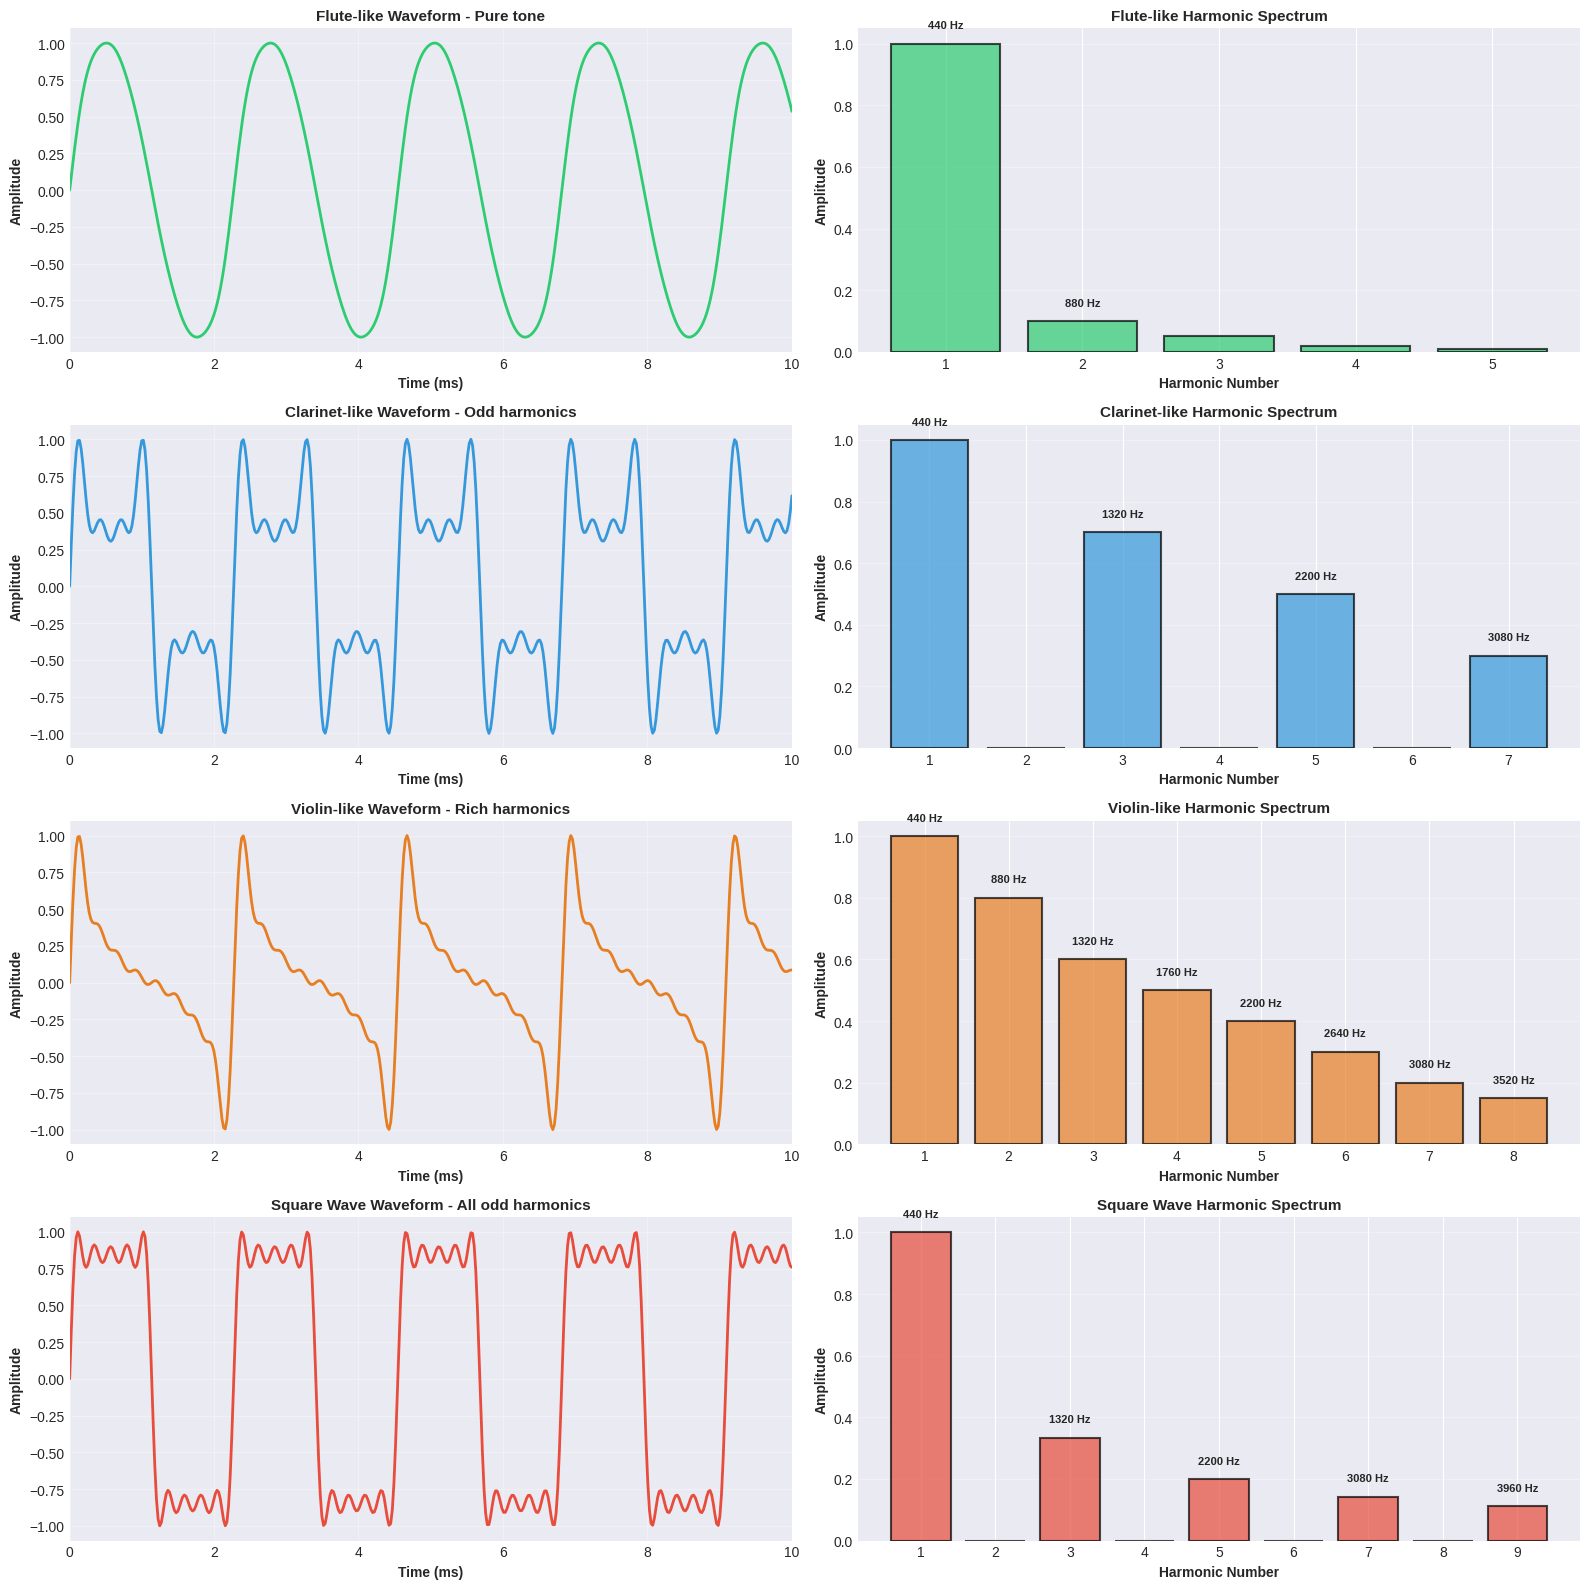


🎵 Harmonic Content Characteristics:
   FLUTE: Strong fundamental, weak harmonics → Pure, clear tone
   CLARINET: Odd harmonics dominant → Hollow, woody sound
   VIOLIN: Rich, balanced harmonics → Warm, complex tone
   SQUARE WAVE: All odd harmonics (1/n) → Buzzy, synthetic sound

💡 Key Insight:
   Same fundamental frequency (440 Hz) but different harmonic content
   → Different timbre → Different perceived sound quality


In [4]:
# Demonstrate superposition of sinusoids to create complex sounds
sr = 44100
duration = 0.05  # 50ms for visualization
t = np.linspace(0, duration, int(sr * duration))
f0 = 440  # A4

# Generate harmonics
def generate_harmonic_series(t, f0, num_harmonics, amplitudes):
    """
    Generate a complex sound from harmonic series
    
    Parameters:
    - t: Time array
    - f0: Fundamental frequency
    - num_harmonics: Number of harmonics to include
    - amplitudes: List of amplitudes for each harmonic
    """
    signal = np.zeros_like(t)
    for n in range(1, num_harmonics + 1):
        if n <= len(amplitudes):
            signal += amplitudes[n-1] * np.sin(2 * np.pi * n * f0 * t)
    return signal

# Different harmonic profiles
# Pure tone (flute-like): Strong fundamental only
flute_amps = [1.0, 0.1, 0.05, 0.02, 0.01]

# Clarinet-like: Odd harmonics dominant
clarinet_amps = [1.0, 0.0, 0.7, 0.0, 0.5, 0.0, 0.3]

# Violin-like: Rich harmonic content
violin_amps = [1.0, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2, 0.15]

# Square wave: All odd harmonics with 1/n amplitude
square_amps = [1.0, 0.0, 1/3, 0.0, 1/5, 0.0, 1/7, 0.0, 1/9]

# Generate signals
flute_signal = generate_harmonic_series(t, f0, 5, flute_amps)
clarinet_signal = generate_harmonic_series(t, f0, 7, clarinet_amps)
violin_signal = generate_harmonic_series(t, f0, 8, violin_amps)
square_signal = generate_harmonic_series(t, f0, 9, square_amps)

# Normalize
flute_signal /= np.max(np.abs(flute_signal))
clarinet_signal /= np.max(np.abs(clarinet_signal))
violin_signal /= np.max(np.abs(violin_signal))
square_signal /= np.max(np.abs(square_signal))

# Visualize
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

signals = [
    (flute_signal, flute_amps, 'Flute-like', '#2ECC71', 'Pure tone'),
    (clarinet_signal, clarinet_amps, 'Clarinet-like', '#3498DB', 'Odd harmonics'),
    (violin_signal, violin_amps, 'Violin-like', '#E67E22', 'Rich harmonics'),
    (square_signal, square_amps, 'Square Wave', '#E74C3C', 'All odd harmonics')
]

for idx, (sig, amps, name, color, desc) in enumerate(signals):
    # Plot waveform
    axes[idx, 0].plot(t * 1000, sig, linewidth=2, color=color)
    axes[idx, 0].set_xlabel('Time (ms)', fontsize=10, fontweight='bold')
    axes[idx, 0].set_ylabel('Amplitude', fontsize=10, fontweight='bold')
    axes[idx, 0].set_title(f'{name} Waveform - {desc}', fontsize=11, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].set_xlim(0, 10)  # First 10ms
    
    # Plot harmonic spectrum
    harmonics = np.arange(1, len(amps) + 1)
    bars = axes[idx, 1].bar(harmonics, amps, color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[idx, 1].set_xlabel('Harmonic Number', fontsize=10, fontweight='bold')
    axes[idx, 1].set_ylabel('Amplitude', fontsize=10, fontweight='bold')
    axes[idx, 1].set_title(f'{name} Harmonic Spectrum', fontsize=11, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3, axis='y')
    axes[idx, 1].set_xticks(harmonics)
    
    # Add frequency labels
    for h, amp in zip(harmonics, amps):
        if amp > 0.05:
            axes[idx, 1].text(h, amp + 0.05, f'{int(h*f0)} Hz',
                            ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎵 Harmonic Content Characteristics:")
print("   FLUTE: Strong fundamental, weak harmonics → Pure, clear tone")
print("   CLARINET: Odd harmonics dominant → Hollow, woody sound")
print("   VIOLIN: Rich, balanced harmonics → Warm, complex tone")
print("   SQUARE WAVE: All odd harmonics (1/n) → Buzzy, synthetic sound")
print("\n💡 Key Insight:")
print("   Same fundamental frequency (440 Hz) but different harmonic content")
print("   → Different timbre → Different perceived sound quality")

---

## 10. 🎼 Amplitude & Frequency Modulation

### 🔹 Amplitude Modulation (AM) - Tremolo

**Definition**: Periodic variation in amplitude

**Formula**:
$$y(t) = [1 + m \cdot \cos(2\pi f_m t)] \cdot \cos(2\pi f_c t)$$

Where:
- $m$ = Modulation depth (0 to 1)
- $f_m$ = Modulation frequency (typically 4-8 Hz for tremolo)
- $f_c$ = Carrier frequency

**Effect**: Creates a "wobbling" or "pulsing" amplitude

### 🔹 Frequency Modulation (FM) - Vibrato

**Definition**: Periodic variation in frequency

**Formula**:
$$y(t) = \cos(2\pi f_c t + \beta \cdot \sin(2\pi f_m t))$$

Where:
- $\beta$ = Modulation index (frequency deviation in Hz)
- $f_m$ = Modulation frequency (typically 5-7 Hz for vibrato)
- $f_c$ = Carrier frequency

**Effect**: Creates a "warbling" pitch variation

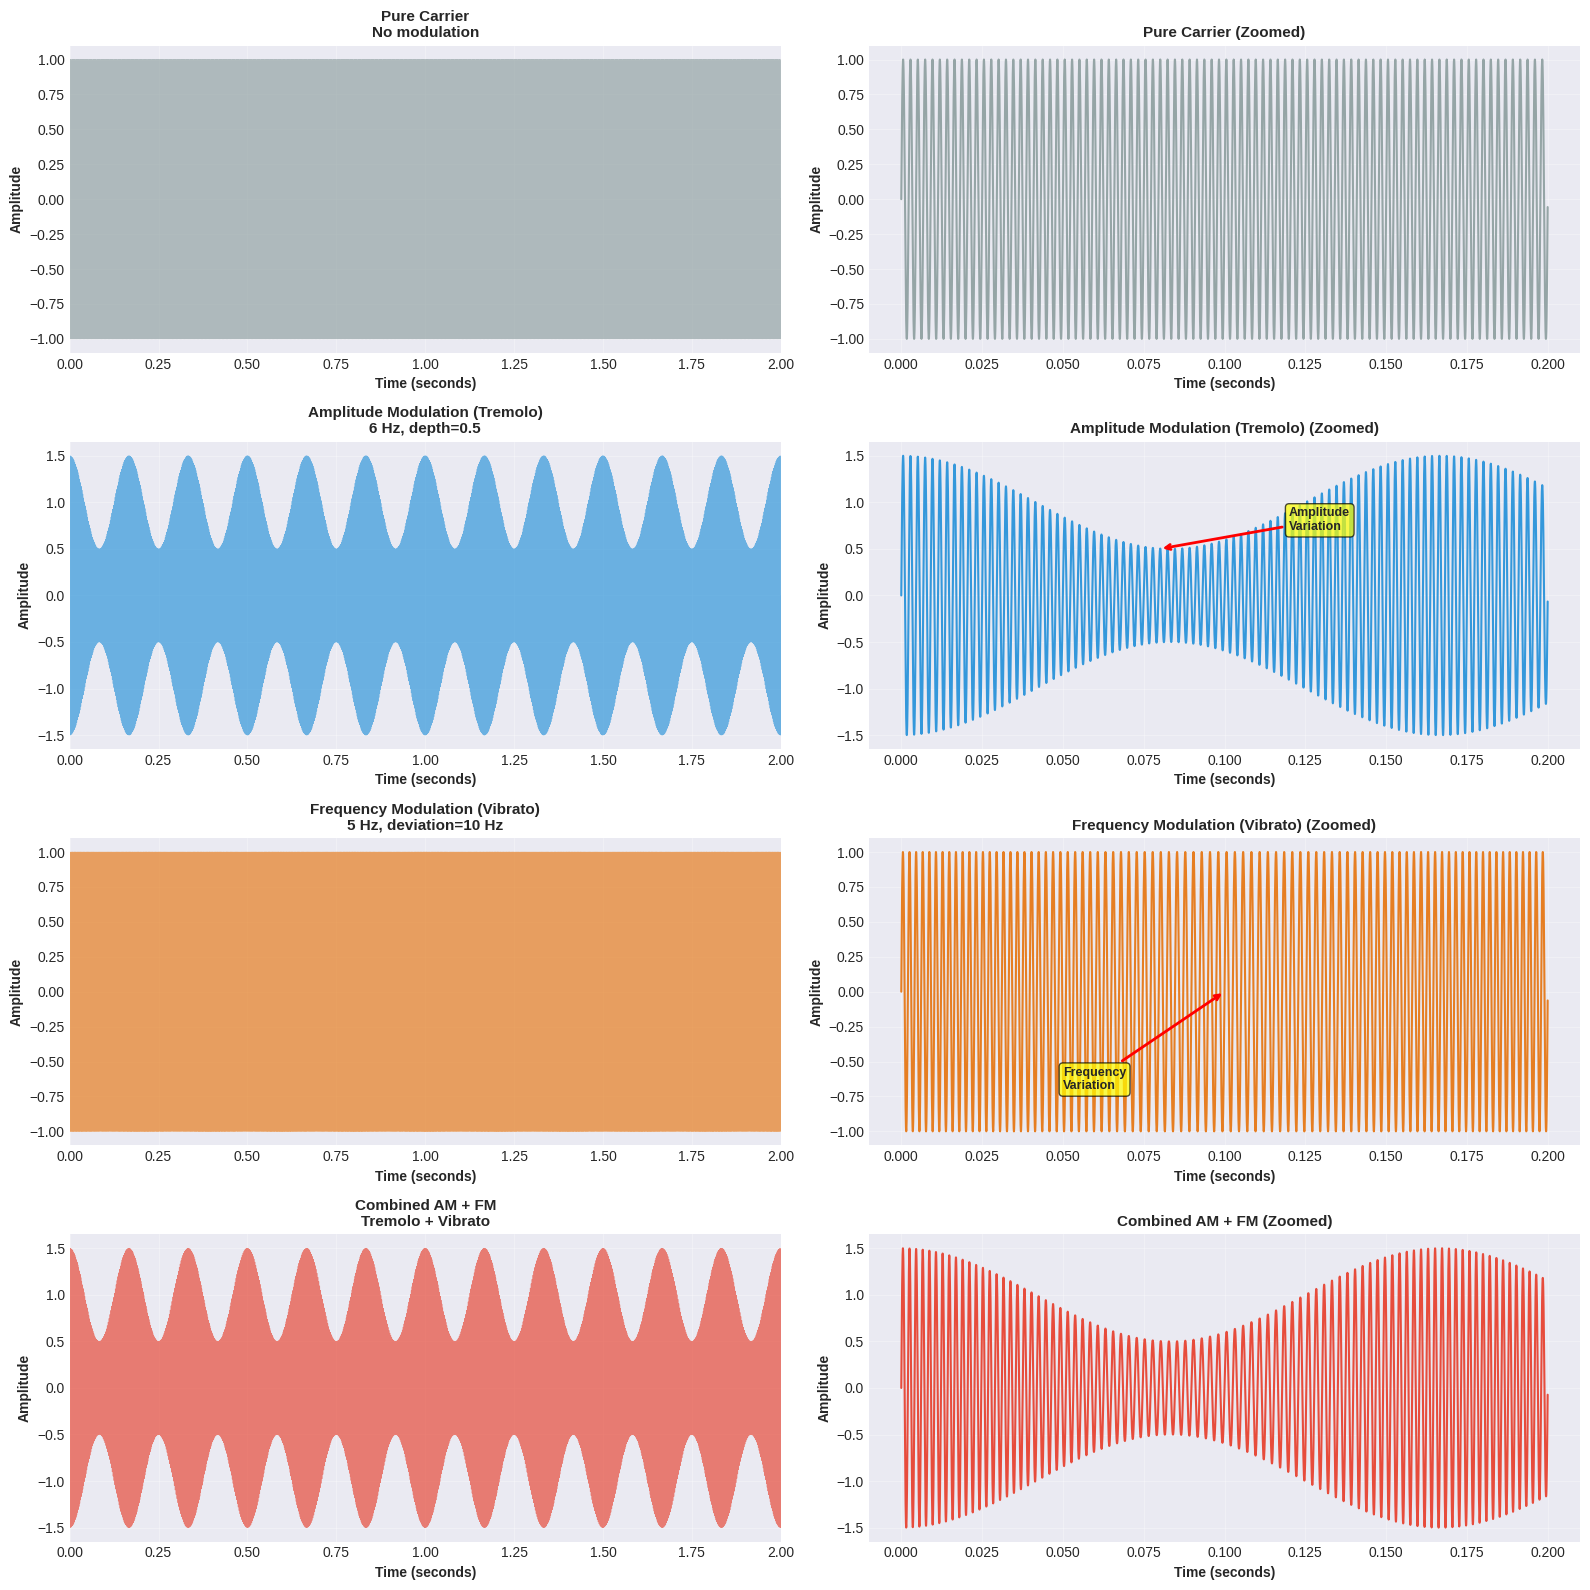


🎵 Modulation Effects:
   AMPLITUDE MODULATION (Tremolo):
   • Periodic variation in volume
   • Creates pulsing/wobbling effect
   • Common in guitar amplifiers, organs

   FREQUENCY MODULATION (Vibrato):
   • Periodic variation in pitch
   • Creates warbling effect
   • Natural in singing, string instruments

   COMBINED:
   • Both amplitude and frequency vary
   • Rich, expressive sound
   • Common in synthesizers


In [5]:
# Demonstrate Amplitude and Frequency Modulation
sr = 44100
duration = 2.0
t = np.linspace(0, duration, int(sr * duration))

# Carrier frequency
fc = 440  # A4

# Pure carrier (no modulation)
carrier = np.sin(2 * np.pi * fc * t)

# Amplitude Modulation (Tremolo)
fm_tremolo = 6  # 6 Hz modulation
m = 0.5  # 50% modulation depth
am_signal = (1 + m * np.cos(2 * np.pi * fm_tremolo * t)) * np.sin(2 * np.pi * fc * t)

# Frequency Modulation (Vibrato)
fm_vibrato = 5  # 5 Hz modulation
beta = 10  # 10 Hz frequency deviation
fm_signal = np.sin(2 * np.pi * fc * t + beta * np.sin(2 * np.pi * fm_vibrato * t))

# Combined AM + FM
combined_signal = (1 + m * np.cos(2 * np.pi * fm_tremolo * t)) * \
                  np.sin(2 * np.pi * fc * t + beta * np.sin(2 * np.pi * fm_vibrato * t))

# Visualize
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

signals = [
    (carrier, 'Pure Carrier', '#95A5A6', 'No modulation'),
    (am_signal, 'Amplitude Modulation (Tremolo)', '#3498DB', f'{fm_tremolo} Hz, depth={m}'),
    (fm_signal, 'Frequency Modulation (Vibrato)', '#E67E22', f'{fm_vibrato} Hz, deviation={beta} Hz'),
    (combined_signal, 'Combined AM + FM', '#E74C3C', 'Tremolo + Vibrato')
]

for idx, (sig, name, color, desc) in enumerate(signals):
    # Plot full waveform
    axes[idx, 0].plot(t, sig, linewidth=0.5, color=color, alpha=0.7)
    axes[idx, 0].set_xlabel('Time (seconds)', fontsize=10, fontweight='bold')
    axes[idx, 0].set_ylabel('Amplitude', fontsize=10, fontweight='bold')
    axes[idx, 0].set_title(f'{name}\n{desc}', fontsize=11, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].set_xlim(0, 2)
    
    # Plot zoomed section (first 0.2 seconds)
    zoom_samples = int(0.2 * sr)
    axes[idx, 1].plot(t[:zoom_samples], sig[:zoom_samples], linewidth=1.5, color=color)
    axes[idx, 1].set_xlabel('Time (seconds)', fontsize=10, fontweight='bold')
    axes[idx, 1].set_ylabel('Amplitude', fontsize=10, fontweight='bold')
    axes[idx, 1].set_title(f'{name} (Zoomed)', fontsize=11, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Add annotations for modulation effects
    if idx == 1:  # AM
        axes[idx, 1].annotate('Amplitude\nVariation', xy=(0.08, 0.5), xytext=(0.12, 0.7),
                             fontsize=9, fontweight='bold',
                             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                             arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    elif idx == 2:  # FM
        axes[idx, 1].annotate('Frequency\nVariation', xy=(0.1, 0), xytext=(0.05, -0.7),
                             fontsize=9, fontweight='bold',
                             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                             arrowprops=dict(arrowstyle='->', lw=2, color='red'))

plt.tight_layout()
plt.show()

print("\n🎵 Modulation Effects:")
print("   AMPLITUDE MODULATION (Tremolo):")
print("   • Periodic variation in volume")
print("   • Creates pulsing/wobbling effect")
print("   • Common in guitar amplifiers, organs")
print("\n   FREQUENCY MODULATION (Vibrato):")
print("   • Periodic variation in pitch")
print("   • Creates warbling effect")
print("   • Natural in singing, string instruments")
print("\n   COMBINED:")
print("   • Both amplitude and frequency vary")
print("   • Rich, expressive sound")
print("   • Common in synthesizers")

---

## 11. 📚 Summary

### 🔹 Key Takeaways

1. **Intensity vs Loudness**:
   - Intensity: Objective physical measurement (W/m²)
   - Loudness: Subjective perception (phons)
   - Relationship: Logarithmic (dB scale)

2. **Equal Loudness Contours**:
   - Frequency-dependent perception
   - Most sensitive: 2-5 kHz
   - Implications for audio engineering and ML

3. **Timbre**:
   - The "color" of sound
   - Primary feature for audio classification
   - Defined by envelope and harmonic content

4. **ADSR Envelope**:
   - Attack, Decay, Sustain, Release
   - Characterizes temporal evolution
   - Different for each instrument

5. **Harmonic Content**:
   - Superposition of sinusoids
   - Fundamental + harmonics
   - Determines timbral quality

6. **Modulation**:
   - AM (Tremolo): Amplitude variation
   - FM (Vibrato): Frequency variation
   - Adds expressiveness to sound

### 🔹 Next Steps

In upcoming notebooks, we'll explore:
- **Spectrograms**: Visualizing frequency content over time
- **MFCCs**: Mel-Frequency Cepstral Coefficients
- **Feature Extraction**: Extracting timbre features for ML
- **Audio Classification**: Using these features for genre/instrument recognition

### 🔹 For Machine Learning

Understanding these concepts is crucial because:
- Raw audio waveforms are not ideal ML features
- We need to extract **perceptually relevant** features
- Timbre features (MFCCs, spectral features) capture what makes sounds different
- These features enable effective audio classification